In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path


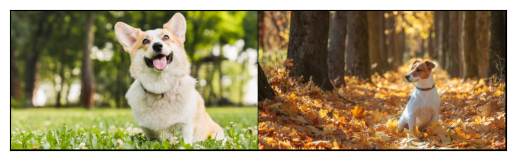

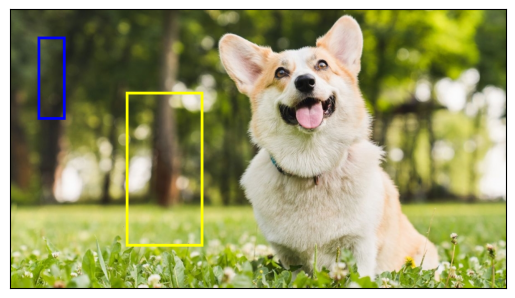

In [6]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


ROOT = Path("/kaggle/input/test-data/data")
dog1_int = read_image('/kaggle/input/test-data/data/dog1.jpg')
dog2_int = read_image('/kaggle/input/test-data/data/dog2.jpg')
dog_list = [dog1_int, dog2_int]

grid = make_grid(dog_list)
show(grid)

from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)


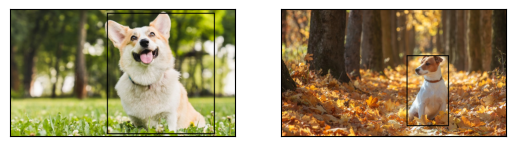

In [14]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
# print(outputs)

score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(dog_list, outputs)
]
show(dogs_with_boxes)

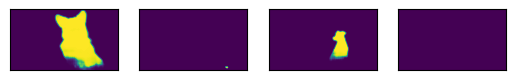

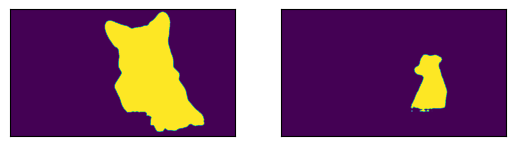

In [15]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
# print(output.shape, output.min().item(), output.max().item())
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
# print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

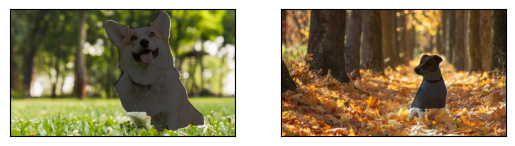

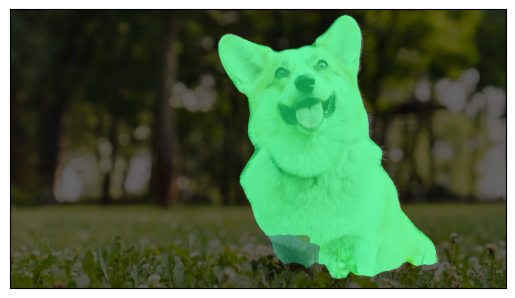

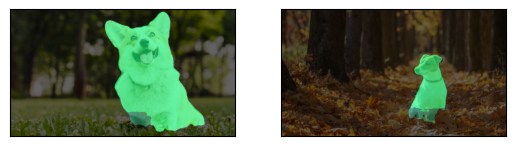

In [17]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(dog_list, boolean_dog_masks)
]
show(dogs_with_masks)
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

# print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
# print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
# print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(dog_list, all_classes_masks)
]
show(dogs_with_masks)

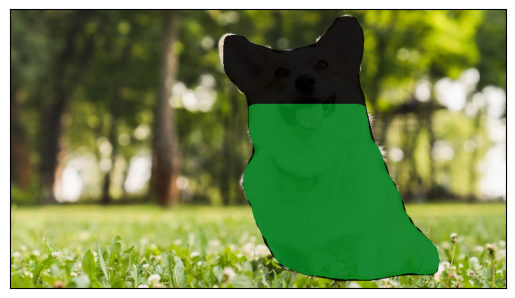

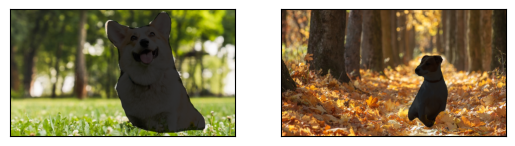

In [18]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
# print(output)
dog1_output = output[0]
dog1_masks = dog1_output['masks']
# print(f"shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}, "
#       f"min = {dog1_masks.min()}, max = {dog1_masks.max()}")
# print("For the first dog, the following instances were detected:")
# print([weights.meta["categories"][label] for label in dog1_output['labels']])
proba_threshold = 0.5
dog1_bool_masks = dog1_output['masks'] > proba_threshold
# print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
dog1_bool_masks = dog1_bool_masks.squeeze(1)

show(draw_segmentation_masks(dog1_int, dog1_bool_masks, alpha=0.9))
# print(dog1_output['scores'])
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(dog_list, boolean_masks)
]
show(dogs_with_masks)
